This notebook replicates key steps of "The Macro-Dynamics of Sorting between Workers and Firms" by Jeremy Lise and Jean-Marc Robin: https://www.aeaweb.org/articles?id=10.1257/aer.20131118

# Model
The economy consists of workers with ability $x \sim Beta(\beta_1,\beta_2)$ and firms with productivity $y\sim{U}(y)$, both with a measure of one. The beginning of period mass of employed and unemployed workers, $h_t(x,y)$ and $u_t(x)$, are such that $u_t(x) + \int h_t(x,y)\,dy=l(x)$. 

An aggregate shock, $z$, which follows a Markov chain with transition probability $\pi(z,z')$, hits the economy and might result in the termination of a job. The post-shock measure are $h_{t+}(x,y)$ and $u_{t+}(x)$. 

It is assumed that workers costlessly search with different intensities: employed workers search with $s$ and unemloyed with $1$. The aggregate effort is $L_t = \int 1\cdot u_{t+}(x)\, dx + \int \int s \cdot h_{t+}(x,y) \, dx \,dy$. Firms post $v_t(y)$ job opportunities for a cost $c(v)$. Aggregate opportunities are $V_t = \int v_t(y)\,dy$. Meetings are assigned randomly with meeting technology $M_t=M(L_t, V_t)=\min \Big( \alpha L_t^\omega V_t^{1-\omega}, L_t, V_t \Big)$. The meeting probabilities for an unemployed and an employed worker are $\lambda_t=\frac{M_t}{L_t}$ and $s\lambda_t$. The meeting probabiliby per posted opportunity is $q_t=\frac{M_t}{V_t}$.

The joint value of a match, $P_t(x,y)$, is the value of a match and includes continuation values of the worker and the firm. The value of being unemployed is $B_{t}(x)$. A match is dissolved if $\mathbb{1}\Big(P_{t+1}(x,y)<B_{t+1}(x)\Big) + \delta \cdot \mathbb{1}\Big(P_{t+1}(x,y) \geq B_{t+1}(x)\Big)$, where $\delta$ is the exogenous separation rate.

The unemployed worker engages in home production $b(x,z_t)$ and values being unemployed:
$$B_t(x) = b(x,z_t) + \frac{1}{1+r} \mathbb{E}_t B_{t+1}(x)$$
Let $S_t(x,y) = P_t(x,y) - B_t(x)$ be the match surplus, then proposition 1 defines the equilibrium to be such that:

$$S(x,y,z) = s(x,y,z) + \frac{1-\delta}{1+r} \int S(x,y,z')^+ \pi(z,z') \, dz'$$
where $s(x,y,z) = p(x,y,z) - b(x,z)$ and $x^+ = \max\Big(x,0\Big)$.



# Implementation

## Definitions

In [1]:
using Parameters
using Distributions
using Plots; pyplot()

include("utils.jl");

In [2]:
?LiseRobinModel

search:



This type stores the parameters of the economy and some technical parameters.

##### Fields

  * `β1::Float64`: Coefficient of Beta distribution of worker types
  * `β2::Float64`: Coefficient of Beta distribution of worker types
  * `c0::Float64`: Scale of cost opportunity posting function
  * `c1::Float64`: Exponent on v of cost opportunity posting function
  * `α::Float64`: Scale of meeting function
  * `ω::Float64`: Exponent on L of meeting function
  * `r::Float64`: Interest rate
  * `δ::Float64`: Exogenous match distruction rate
  * `f0::Float64`: Price scale (used for GDP scaling)
  * `p1::Float64`: Constant in production function
  * `p2::Float64`: Coefficient in production function
  * `p3::Float64`: Coefficient in production function
  * `p4::Float64`: Coefficient in production function
  * `p5::Float64`: Coefficient in production function
  * `p6::Float64`: Coefficient in production function
  * `σ::Float64`: Volatility of z
  * `ρ::Float64`: AR of z
  * `s::Float64`: Search intensity of employed
  * `dt::Float64`: Length of one time period
  * `ϵ::Float64`: Distance of left/right grid element to boundary
  * `Nx::Int64`: Number of grid points in x
  * `Ny::Int64`: Number of grid points in y
  * `Nz::Int64`: Number of grid points in z
  * `Gridx::Vector{Float64}`: Grid on x
  * `Gridy::Vector{Float64}`: Grid on y
  * `Gridz::Vector{Float64}`: Grid on z
  * `Grida::Vector{Float64}`: Grid on a, the random variable of the copula

```
LiseRobinModel()
```

This is a constructor of a LiseRobinModel with parameters from table 2, unless otherwise specified.


I set the parameters at the levels estimated in the paper.

In [3]:
model = LiseRobinModel(Nx=101, Ny=101, Nz=101);

## Solving for S

In [4]:
?solveS

search:



```
solveS(model)
```

This function iterates on equation (3) until convergence. 

##### Returns

  * `S::Array{Float64,3}`: Surplus as a function of x, y, z
  * `B::Array{Float64,1}`: Value of unemploymend as a function of x
  * `P::Array{Float64,3}`: Value of a match as a function of x, y, z
  * `l::Array{Float64,1}`: Worker density as a function of x
  * `p::Array{Float64,3}`: Production as a function of x, y, z
  * `b::Array{Float64,1}`: Home production as a function of x
  * `Speriod::Array{Float64,3}`: Period surplus as a function of x, y, z
  * `Q::Array{Float64,2}`: Transition probabilities from z to z'


In [5]:
@time (S, B, P, l, p, b, Speriod, Q) = solveS(model);

 65.208817 seconds (2.19 M allocations: 40.011 GiB, 38.42% gc time)



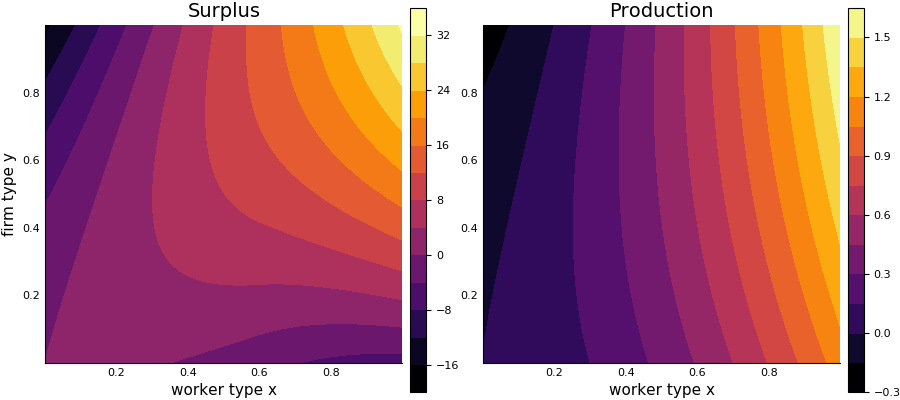

In [6]:
p1 = contour(model.Gridx, model.Gridy, S[:, :, 26]', fill=true, title="Surplus", label="Surplus", ylab="firm type y")
p2 = contour(model.Gridx, model.Gridy, p[:, :, 26]', fill=true, title="Production", label="Production")
plot(p1, p2, size=(900,400), xlab="worker type x")

The stationary distribution of $z$ is:

In [7]:
(D, V) = eig(Q')
index = find((D .≈ 1) .* prod((V ./sum(V, 1)) .>= -1e-8, 1)')[2];


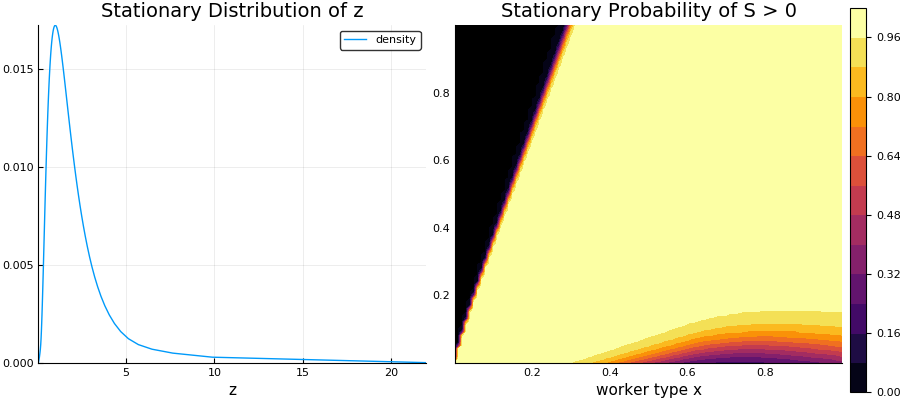

In [8]:
p1 = plot(exp.(model.Gridz), V[:, index]/sum(V[:, index]), title="Stationary Distribution of z", label="density", xlab="z")
p2 = contour(model.Gridx, model.Gridy, 
    (sum(permutedims(S .>= 0, [3, 1, 2]) .* V[:, index]/sum(V[:, index]), 1))[1, :, :]', fill=true, 
    title="Stationary Probability of S > 0", label="S > 0", background_color_inside="black", xlab="worker type x")
plot(p1, p2, size=(900,400))

## Deterministic Steady State for h

In [9]:
?fixedpointh

search:



```
fixedpointh(model, S, l)
```

This function iterates on equation (9) until convergence.

##### Returns

  * `h::Vector{Float64}`: Distribution of employed workers as a function of x, y


In [10]:
@time (h0, w0) = fixedpointh(model, S[:, :, convert(Int,(model.Nz+1)/2)], l);

 37.668941 seconds (18.07 M allocations: 26.563 GiB, 14.15% gc time)


The deterministic steady state distribution of matches is:


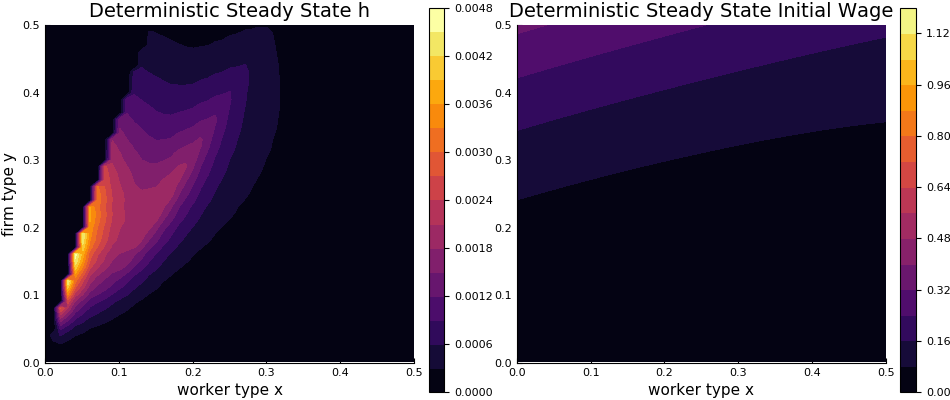

In [11]:
p1 = contour(model.Gridy, model.Gridx, h0'/sum(h0), xlim=[0, 0.5], ylim=[0, 0.5], fill=true, title="Deterministic Steady State h", ylab="firm type y")
p2 = contour(model.Gridy, model.Gridx, w0, xlim=[0, 0.5], ylim=[0, 0.5], fill=true, title="Deterministic Steady State Initial Wage")
plot(p1, p2, xlab="worker type x", size=(950,400))


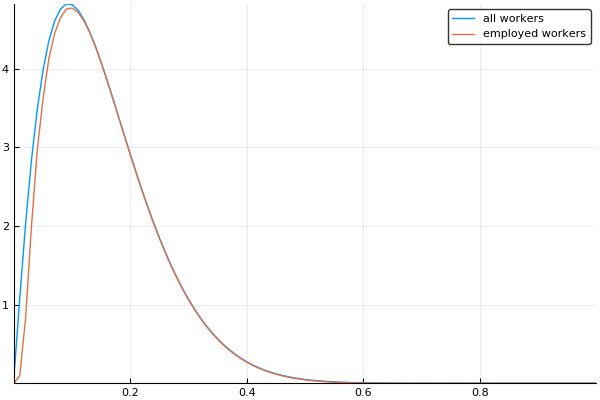

In [12]:
p1 = plot(model.Gridx, l, label="all workers")
p1 = plot!(model.Gridx, sum(h0, 2)/model.Nx, label="employed workers")

Unemployment is concentrated among low type workers.

## Simulation

In [13]:
?simulateh

search:



```
simulateh(model, S, h0, Q)
```

This function simulates 600 years and estimates stationary distributions and flow masses.

##### Returns

(sim_h, sim_J2J, sim_E2U, sim_HfU, sim_HfE)

  * `sim_h::Array{Float64,2}`: Distribution of employed workers as a function of x, y
  * `sim_J2J::Array{Float64,2}`: Flow mass of job-to-job transitions as a function of x, y
  * `sim_E2U::Array{Float64,2}`: Flow mass of unemployed-to-employment transitions as a function of x, y
  * `sim_HfU::Array{Float64,2}`: Flow mass of hires from unemployment as a function of x, y
  * `sim_HfE::Array{Float64,2}`: Flow mass of poached hires as a function of x, y


A run with $Nx=Ny=Nz=101$ should take 15 minutes or shorter:

In [14]:
@time (ts_z, sim_h, sim_J2J, sim_E2U, sim_HfU, sim_HfE) = simulateh(model, S, h0, Q);

832.279104 seconds (131.59 M allocations: 1.167 TiB, 29.66% gc time)



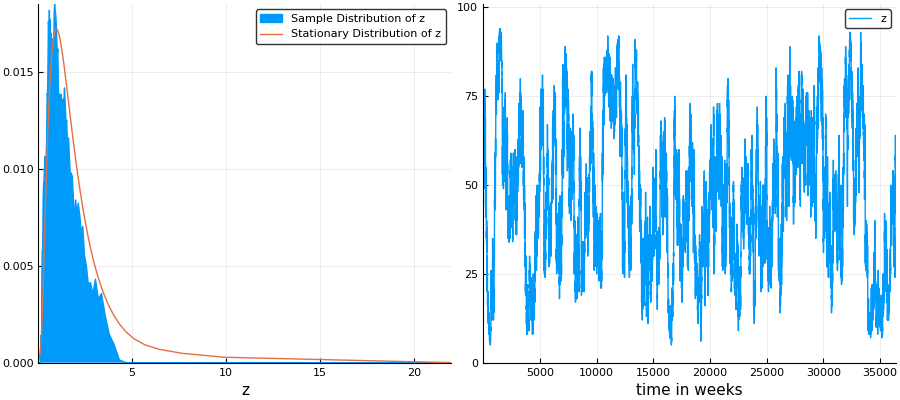

In [15]:
sampledensity = [count(model.Gridz[ts_z] .== model.Gridz[z]) for z in 1:model.Nz]/length(ts_z)
p1 = plot(exp.(model.Gridz), sampledensity, label="Sample Distribution of z", xlab="z", fill=true)
p1 = plot!(exp.(model.Gridz), V[:, index]/sum(V[:, index]), title="", label="Stationary Distribution of z", xlab="z")
p2 = plot(ts_z, ylim=[0, model.Nz], t=[:line :histogram], label="z", xlab="time in weeks")
plot(p1, p2, size=(900,400))


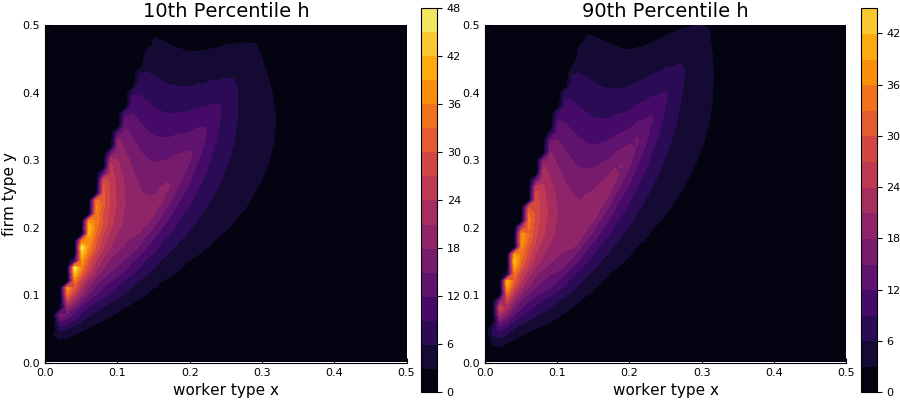

In [16]:
p1 = contour(model.Gridy, model.Gridx, sim_h[:, :, minimum(find(cumsum(sampledensity) .>= 0.1))]', xlim=[0, 0.5], ylim=[0, 0.5], fill=true, ylab="firm type y", title="10th Percentile h", clims=(0, 50))
p2 = contour(model.Gridy, model.Gridx, sim_h[:, :, minimum(find(cumsum(sampledensity) .>= 0.9))]', xlim=[0, 0.5], ylim=[0, 0.5], fill=true, title="90th Percentile h", clims=(0, 50))
plot(p1, p2, size=(900,400), xlab="worker type x")

There is more mass on the border in a recession than in an expansion. Furthermore, the second ridge be seen clearly.


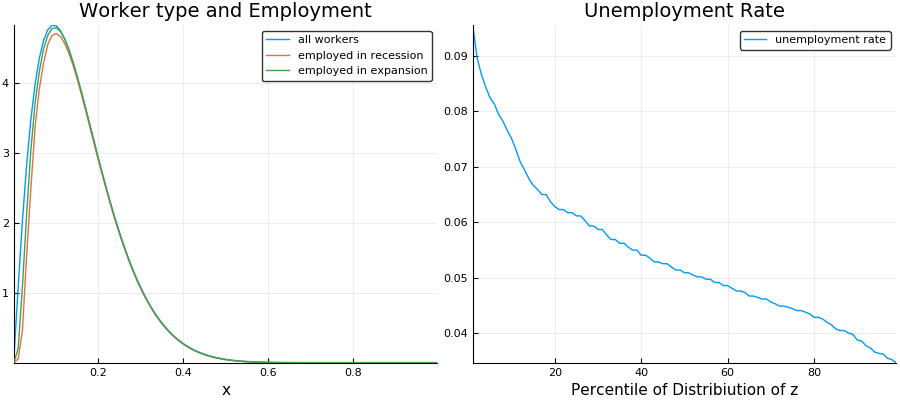

In [17]:
p1 = plot(model.Gridx, l, label="all workers", xlab="x", title="Worker type and Employment")
p1 = plot!(model.Gridx, sum(sim_h[:, :, minimum(find(cumsum(sampledensity) .>= 0.1))], 2)/model.Nx, label="employed in recession")
p1 = plot!(model.Gridx, sum(sim_h[:, :, minimum(find(cumsum(sampledensity) .>= 0.9))], 2)/model.Nx, label="employed in expansion")
p2 = plot((0.01:0.01:0.99)*100, [1 - sum(sim_h[:, :, minimum(find(cumsum(sampledensity) .>= i))])/model.Nx/model.Ny for i in 0.01:0.01:0.99], label="unemployment rate", title="Unemployment Rate", xlab="Percentile of Distribiution of z")
plot(p1, p2, size=(900,400))


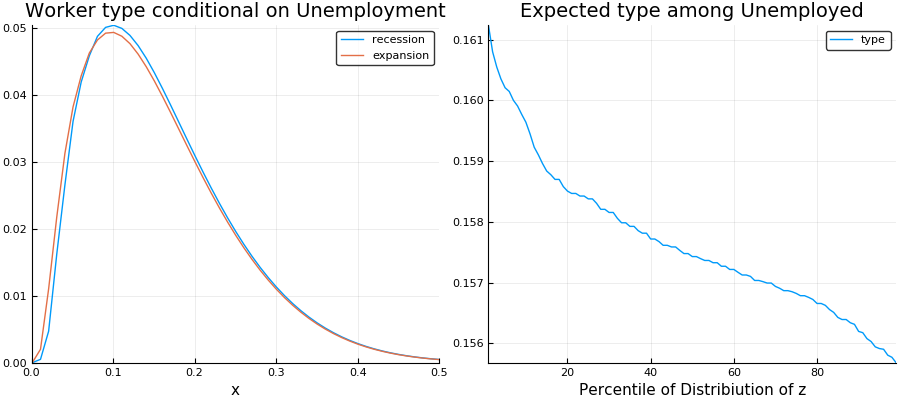

In [18]:
p1 = plot(model.Gridx, (l - sum(sim_h[:, :, minimum(find(cumsum(sampledensity) .>= 0.1))], 2))/sum(l - sum(sim_h[:, :, minimum(find(cumsum(sampledensity) .>= 0.1))], 2)), label="recession", xlab="x", title="Worker type conditional on Unemployment", xlim=[0, 0.5])
p1 = plot!(model.Gridx, (l - sum(sim_h[:, :, minimum(find(cumsum(sampledensity) .>= 0.9))], 2))/sum(l - sum(sim_h[:, :, minimum(find(cumsum(sampledensity) .>= 0.9))], 2)), label="expansion")

p2 = plot((0.01:0.01:0.99)*100, [(((l - sum(sim_h[:, :, minimum(find(cumsum(sampledensity) .>= i))], 2))/sum(l - sum(sim_h[:, :, minimum(find(cumsum(sampledensity) .>= i))], 2)))' * model.Gridx)[1] for i in 0.01:0.01:0.99], label="type", title="Expected type among Unemployed", xlab="Percentile of Distribiution of z")

plot(p1, p2, size=(900,400))

There is very little variation of the distribution of unemployed worker types over the business cycle.

In [19]:
using ReadStat
data_J2J = read_dta("j2j.dta")
data_U2E = read_dta("U2E.dta");


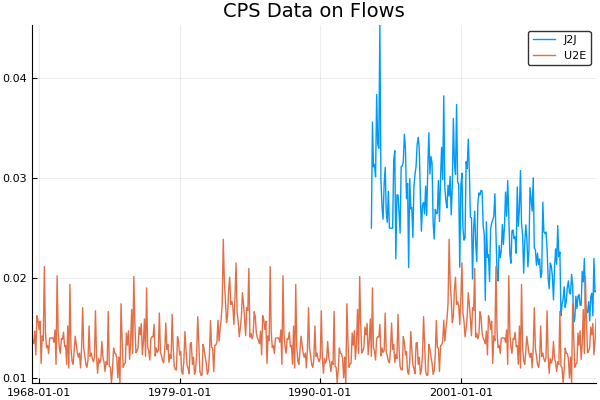

In [20]:
ts_j2j = convert(Array, data_J2J[1][6], 0.025)
ts_u2e = convert(Array, data_U2E[1][6], 0.014)[320:531]

plot([Date(convert(Array, data_J2J[1][1])[i], convert(Array, data_J2J[1][3])[i]) for i in 1:length(data_J2J[1][1])], ts_j2j, label="J2J", title="CPS Data on Flows")
plot!([Date(convert(Array, data_U2E[1][1])[i], convert(Array, data_U2E[1][3])[i]) for i in 1:length(data_U2E[1][1])], ts_u2e, label="U2E")

The flow from unemployement to employment increases when the unemployment rate is higher. 

## Efficiency Losses due to Missallocation

In [46]:
Pkg.add("Clp")

INFO: Cloning cache of Cbc from https://github.com/JuliaOpt/Cbc.jl.git
INFO: Cloning cache of Clp from https://github.com/JuliaOpt/Clp.jl.git
INFO: Installing Cbc v0.3.2
INFO: Installing Clp v0.3.1
INFO: Building Cbc
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of Clp
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [55]:
using JuMP, Clp, Ipopt

i = 0.01
z = minimum(find(cumsum(sampledensity) .>= i))
Φ = p[:, :, z]
Φ = hcat(Φ, b)
Φ = vcat(Φ, zeros(model.Nx + 1)')

#m = Model(solver=ClpSolver(LogLevel=4))
m = Model(solver=IpoptSolver())
@time @variable(m, π[1:(model.Nx+1), 1:(model.Ny+1)] >= 0)

for x in 1:model.Nx
    setvalue(π[x, model.Ny+1],  l[x]/model.Nx)
end

@time @constraint(m, distx[x=1:model.Nx], sum(π[x, y] for y in 1:model.Ny) == l[x]/model.Nx)
@time @constraint(m, disty[y=1:model.Ny], sum(π[x, y] for x in 1:model.Nx) == 1/model.Ny)

@time @objective(m, Max, sum(sum(π[x, y] * Φ[x, y] for x in 1:(model.Nx+1)) for y in 1:(model.Ny+1)))



  0.013902 seconds (62.73 k allocations: 3.497 MiB)
  0.005564 seconds (12.34 k allocations: 799.078 KiB)
  0.004414 seconds (12.23 k allocations: 797.375 KiB)
  0.004714 seconds (21.05 k allocations: 1007.813 KiB)


0.0005220874970970736 π[1,1] + 0.0028025522723973137 π[2,1] + 0.005252665608067986 π[3,1] + 0.007872427504109089 π[4,1] + 0.010661837960520629 π[5,1] + 0.0136208969773026 π[6,1] + 0.016749604554455 π[7,1] + 0.02004796069197784 π[8,1] + 0.0235159653898711 π[9,1] + 0.027153618648134804 π[10,1] + 0.030960920466768935 π[11,1] + 0.0349378708457735 π[12,1] + 0.0390844697851485 π[13,1] + 0.04340071728489393 π[14,1] + 0.0478866133450098 π[15,1] + 0.052542157965496085 π[16,1] + 0.057367351146352816 π[17,1] + 0.06236219288757999 π[18,1] + 0.06752668318917758 π[19,1] + 0.07286082205114561 π[20,1] + 0.07836460947348406 π[21,1] + 0.08403804545619295 π[22,1] + 0.08988112999927227 π[23,1] + 0.09589386310272202 π[24,1] + 0.10207624476654223 π[25,1] + 0.10842827499073285 π[26,1] + 0.11494995377529389 π[27,1] + 0.12164128112022535 π[28,1] + 0.12850225702552734 π[29,1] + 0.13553288149119966 π[30,1] + 0.14273315451724247 π[31,1] + 0.15010307610365564 π[32,1] + 0.1576426462504393 π[33,1] + 0.16535186495759

In [ ]:
ge

In [54]:
@time solve(m)

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    20402
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    10404
                     variables with only lower bounds:    10404
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

Not solved to optimality, status: Unbounded


:Unbounded

In [45]:
Φ = p[:, :, z]
Φ = hcat(Φ, b)
Φ = vcat(Φ, zeros(model.Nx + 1)')

102×102 Array{Float64,2}:
 0.000522087  0.000356806  0.000151261  …  -0.211161   -0.215312  0.000403639
 0.00280255   0.0027069    0.00257099      -0.201986   -0.206068  0.00216672 
 0.00525267   0.00522665   0.00516037      -0.192643   -0.196655  0.00406097 
 0.00787243   0.00791605   0.0079194       -0.183129   -0.187072  0.00612269 
 0.0106618    0.0107751    0.0108481       -0.173446   -0.177319  0.00841222 
 0.0136209    0.0138038    0.0139464    …  -0.163593   -0.167397  0.0109263  
 0.0167496    0.0170021    0.0172144       -0.153571   -0.157305  0.0136624  
 0.020048     0.0203701    0.020652        -0.143379   -0.147043  0.0166205  
 0.023516     0.0239077    0.0242593       -0.133017   -0.136612  0.0198089  
 0.0271536    0.027615     0.0280362       -0.122486   -0.126011  0.0232194  
 0.0309609    0.031492     0.0319828    …  -0.111785   -0.11524   0.0268519  
 0.0349379    0.0355386    0.036099        -0.100914   -0.1043    0.0307088  
 0.0390845    0.0397548    0.0403848  